### Analysis of the First PerMU experiemnt

In [1]:
import json
import pandas as pd

In [2]:
df = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_PermUIntext_Experiment1_llama2-7b_E8_B16_rp1.0_kn1/eval_results/eval.csv')

In [7]:
for col in df.columns:
    ## nice print of column name and the value
    if not col.startswith('PII'):
        value = df[col].values[0]
        if isinstance(value, float):
            print(f"Column: {col} - Value: {value:.2f}")
        else:
            print(f"Column: {col} - Value: {value}")

Column: para_scores_forget_exact - Value: 0.02
Column: para_scores_forget_partial_ratio - Value: 0.09
Column: para_scores_forget_token_set_ratio - Value: 0.03
Column: Prob. Forget Paraphrase - Value: 0.33
Column: ROUGE Forget Paraphrase - Value: 0.44
Column: Fluency Forget Paraphrase - Value: 3.78
Column: Truth Ratio Forget Paraphrase - Value: 0.52
Column: para_scores_retain_exact - Value: 0.85
Column: para_scores_retain_partial_ratio - Value: 0.91
Column: para_scores_retain_token_set_ratio - Value: 0.86
Column: Prob. Retain Paraphrase - Value: 0.67
Column: ROUGE Retain Paraphrase - Value: 0.63
Column: Fluency Retain Paraphrase - Value: 3.90
Column: Truth Ratio Retain Paraphrase - Value: 0.71
Column: Prob. Retain - Value: 0.92
Column: ROUGE Retain - Value: 0.85
Column: Truth Ratio Retain - Value: 0.73
Column: Prob. Real Authors - Value: 0.60
Column: ROUGE Real Authors - Value: 0.93
Column: Truth Ratio Real Authors - Value: 0.75
Column: Prob. Real World - Value: 0.51
Column: ROUGE Real 

In [ ]:
    
import random
def load_targetted_extraction_samples(sample_path: str, seed: int = 42, sample_size: int = 300):
    """Load samples from 'parsed_question', evenly split between 'direct' and 'obscure' styles."""
    df = pd.read_csv(sample_path)

    # Split the data into 'direct' and 'obscure'
    direct_samples = df[df['style'] == 'direct']['parsed_question'].dropna().tolist()
    obscure_samples = df[df['style'] == 'obscure']['parsed_question'].dropna().tolist()

    # Calculate half size
    half_size = sample_size // 2

    # Ensure reproducibility
    random.seed(seed)
    sampled_direct = random.sample(direct_samples, half_size)
    sampled_obscure = random.sample(obscure_samples, sample_size - half_size)  # Covers odd sample_size

    # Combine and return
    return sampled_direct + sampled_obscure

def load_person_split_dict(sample_path,split: str):
    #sample_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/split_person_names'
    test_retain_str = 'test_retain_pii_names'
    
    forget_percentage = int(split.replace('forget', ''))
    retain_percentage = 100 - forget_percentage
    
    forget_str = f'forget{forget_percentage}_names'
    retain_str = f'retain{retain_percentage}_names'
    
    # Load the three name files
    forget_path = f'{sample_path}/{forget_str}.json'
    retain_path = f'{sample_path}/{retain_str}.json'
    test_retain_path = f'{sample_path}/{test_retain_str}.json'
    
    with open(forget_path, 'r') as f:
        forget_names = json.load(f)
    with open(retain_path, 'r') as f:
        retain_names = json.load(f)
    with open(test_retain_path, 'r') as f:
        test_retain_names = json.load(f)
    
    # Create dictionary with person names as keys and split type as values
    person_split_dict = {}
    
    for name in forget_names:
        person_split_dict[name] = 'forget'
    for name in retain_names:
        person_split_dict[name] = 'retain'
    for name in test_retain_names:
        person_split_dict[name] = 'test_retain'
    
    return person_split_dict
extraction_targetted_samples_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/my_files/pii_dataset/data/generated_data/GeneratedPIIQuestions_temp-0.7_top_p-0.9_model-Qwen3-32B-FP8.csv'
TARGETTED_EXTRACTION_PROMPT_SAMPLES = load_targetted_extraction_samples(extraction_targetted_samples_path,seed=23,sample_size=100)
person_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/data/PII/split_person_names'
persons = load_person_split_dict(person_path, split='forget10')

dict_count_per_split = {    'forget': 0,
                            'retain': 0,
                            'test_retain': 0,}

for name, split in persons.items():
    first_name = name.split()[0]

    for prompt in TARGETTED_EXTRACTION_PROMPT_SAMPLES:
        if first_name in prompt:
            if split in dict_count_per_split:
                dict_count_per_split[split] += 1

In [3]:
dict_count_per_split_default = {
    'forget': 200,
    'retain': 1800,
    'test_retain': 250,
}

In [29]:

#### load in the eval_results : What we care about for now : Exact Retain and Exact Forget scores
def load_eval_results(eval_results_path,replace_prob=None,k_distance=None,similarity_method='exact'):
      # Construct the path using the pattern: _PermUIntext_Experiment1_llama2-7b_E8_B16_rp{replace_prob}_kn{k_distance}
    if replace_prob is not None and k_distance is not None:
        eval_results_path = eval_results_path + f"_PermUIntext_Experiment1_llama2-7b_E8_B16_rp{replace_prob}_kn{k_distance}/eval_results/eval_log_aggregated.json"
        
    with open(eval_results_path, 'r') as file:
        eval_results = json.load(file)

    para_scores_retain,exact_retain_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='retain')
    para_scores_forget,exact_forget_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='forget')
    
    one_hop_scores_forget_pii, one_hop_scores_forget_name = get_one_hop_scores(eval_results, type='forget')
    one_hop_scores_retain_pii, one_hop_scores_retain_name = get_one_hop_scores(eval_results, type='test_retain')

    extraction_scores_forget, targetted_extraction_scores_forget = get_extraction_scores(eval_results, type='forget', similarity_method=similarity_method)
    extraction_scores_retain, targetted_extraction_scores_retain = get_extraction_scores(eval_results, type='test_retain', similarity_method=similarity_method)

    inverse_scores_forget = get_inverse_scores(eval_results, type='forget', similarity_method=similarity_method)
    inverse_scores_retain = get_inverse_scores(eval_results, type='retain', similarity_method=similarity_method)

    return {
        'exact_retain_score': exact_retain_score,
        'exact_forget_score': exact_forget_score,
        'para_scores_retain': para_scores_retain,
        'para_scores_forget': para_scores_forget,
        'one_hop_scores_forget_pii': one_hop_scores_forget_pii,
        'one_hop_scores_forget_name': one_hop_scores_forget_name,
        'one_hop_scores_retain_pii': one_hop_scores_retain_pii,
        'one_hop_scores_retain_name': one_hop_scores_retain_name,
        'extraction_scores_forget': extraction_scores_forget,
        'extraction_scores_retain': extraction_scores_retain,
        'targetted_extraction_scores_forget': targetted_extraction_scores_forget,
        'targetted_extraction_scores_retain': targetted_extraction_scores_retain,
        'inverse_scores_forget': inverse_scores_forget,
        'inverse_scores_retain': inverse_scores_retain,
        'replace_prob': replace_prob,
        'k_distance' : k_distance
    }


def get_exact_forgetretain(eval_results,type='forget',similarity_method='exact'):


    exact = eval_results[f"eval_log_{type}.json"][f"avg_pii_autocompletion_{similarity_method}_leakage_score"]

    # Try to get paraphrased forget examples (if available)
    paraphrase_scores = []
    for i in range(1, 6):
        key = f"eval_log_{type}_paraphrase_{i}.json"
        if key in eval_results:
            paraphrase_scores.append(eval_results[key][f"avg_pii_autocompletion_{similarity_method}_leakage_score"])

    # If paraphrases exist, calculate mean; otherwise use original
    if paraphrase_scores:
        paraphrase_scores_mean = (sum(paraphrase_scores)) / (len(paraphrase_scores))
    else:
        paraphrase_scores_mean = None

    return paraphrase_scores_mean, exact


def get_one_hop_scores(eval_results, type = 'forget'):
    pii_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_additional_pii_leakage_rate"]
    name_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_full_name_leakage_rate"]

    return pii_leaked_score, name_leaked_score


def get_inverse_scores(eval_results, type='forget', similarity_method='exact'):
    inverse_scores = eval_results[f"eval_log_{type}_inverse.json"][f"avg_pii_autocompletion_full_name_{similarity_method}_score"]

    return inverse_scores


def get_extraction_scores(eval_results, type='forget', similarity_method='exact'):
    extraction_scores = eval_results['extraction_attack.json']['pii_extraction_results']
    targeted_extraction_scores = eval_results['extraction_attack.json']['targeted_pii_extraction_results']

    extract_leaked_sample_count = 0
    targeted_extract_leaked_sample_count = 0
    for item in extraction_scores:
        extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']

    for item in targeted_extraction_scores:
        targeted_extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']
    leaked_score = extract_leaked_sample_count / dict_count_per_split_default[type]
    targeted_leaked_score = targeted_extract_leaked_sample_count / dict_count_per_split[type]


    return leaked_score, targeted_leaked_score
 

In [34]:

eval_results_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/'
replace_probs = [0.25, 0.5, 0.75, 1.0]
token_k = [1,2,3,4,10]

result_dicts = []

for replace_prob in replace_probs:
    for k_distance in token_k:
        if k_distance == 4:
            continue
        if replace_prob == 0.75 and k_distance == 10:
            continue


        print(f"Loading results for replace_prob: {replace_prob}, k_distance: {k_distance}")
        res = load_eval_results(eval_results_path, replace_prob=replace_prob, k_distance=k_distance, similarity_method='exact')
        result_dicts.append(res)

res_df = pd.DataFrame(result_dicts)

Loading results for replace_prob: 0.25, k_distance: 1
Loading results for replace_prob: 0.25, k_distance: 2
Loading results for replace_prob: 0.25, k_distance: 3
Loading results for replace_prob: 0.25, k_distance: 10
Loading results for replace_prob: 0.5, k_distance: 1
Loading results for replace_prob: 0.5, k_distance: 2
Loading results for replace_prob: 0.5, k_distance: 3
Loading results for replace_prob: 0.5, k_distance: 10
Loading results for replace_prob: 0.75, k_distance: 1
Loading results for replace_prob: 0.75, k_distance: 2
Loading results for replace_prob: 0.75, k_distance: 3
Loading results for replace_prob: 1.0, k_distance: 1
Loading results for replace_prob: 1.0, k_distance: 2
Loading results for replace_prob: 1.0, k_distance: 3
Loading results for replace_prob: 1.0, k_distance: 10


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# import plotly.express as px
# def plot_k_distance(df, score_col='exact_retain_score'):
#     """Plot score vs replace_prob with k_distance as marker size"""
#     data = df[df['k_distance'].isin([1,2,3,10])].copy()
#     data['size'] = data['k_distance'].map({1:8, 2:12, 3:16, 10:20})
    
#     fig = px.scatter(data, x='replace_prob', y=score_col, 
#                     size='size', color='k_distance',
#                     title=f'{score_col} vs Replace Probability')
#     return fig


def plot_k_distance(df, score_col='exact_retain_score'):
    """Plot score vs replace_prob with k_distance as marker size using seaborn"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Create size mapping for different k_distance values
    size_mapping = {1: 50, 2: 100, 3: 150, 10: 200}
    data['size'] = data['k_distance'].map(size_mapping)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot with seaborn
    sns.scatterplot(data=data, x='replace_prob', y=score_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7)
    
    # Customize the plot
    plt.title(f'{score_col} vs Replace Probability')
    plt.xlabel('Replace Probability')
    plt.ylabel(score_col)
    
    # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()


    import seaborn as sns
import matplotlib.pyplot as plt

def plot_k_distance_dual(df, retain_col='exact_retain_score', forget_col='exact_forget_score'):
    """Plot both retain and forget scores vs replace_prob with k_distance as marker size"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Create the subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot retain scores (blue gradient)
    sns.scatterplot(data=data, x='replace_prob', y=retain_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette='Blues', ax=ax1)
    
    ax1.set_title(f'{retain_col} vs Replace Probability')
    ax1.set_xlabel('Replace Probability')
    ax1.set_ylabel(retain_col)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot forget scores (red gradient)
    sns.scatterplot(data=data, x='replace_prob', y=forget_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette='Reds', ax=ax2)
    
    ax2.set_title(f'{forget_col} vs Replace Probability')
    ax2.set_xlabel('Replace Probability')
    ax2.set_ylabel(forget_col)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_k_distance_single(df, score_col='exact_retain_score'):
    """Plot single score vs replace_prob with automatic color selection based on score type"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    # Determine color based on score column name
    if 'retain' in score_col.lower():
        palette = 'Blues'
        color_name = 'Blue'
    elif 'forget' in score_col.lower():
        palette = 'Reds'
        color_name = 'Red'
    else:
        palette = 'viridis'  # Default palette
        color_name = 'Default'
    
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot with appropriate color
    sns.scatterplot(data=data, x='replace_prob', y=score_col, 
                   size='k_distance', hue='k_distance', 
                   sizes=(50, 200), alpha=0.7,
                   palette=palette)
    
    plt.title(f'{score_col} vs Replace Probability ({color_name} Gradient)')
    plt.xlabel('Replace Probability')
    plt.ylabel(score_col)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

# Alternative version with manual gradient control
def plot_k_distance_custom_dual(df, retain_col='exact_retain_score', forget_col='exact_forget_score'):
    """Plot with manually defined gradient colors for more control"""
    data = df[df['k_distance'].isin([1,2,3,10])].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Blue gradient for retain scores
    blue_colors = ['#e6f3ff', '#66b3ff', '#0066cc', '#003366']
    # Red gradient for forget scores  
    red_colors = ['#ffe6e6', '#ff6666', '#cc0000', '#660000']
    
    sizes = [50, 100, 150, 200]
    k_values = [1, 2, 3, 10]
    
    # Plot retain scores
    for i, k in enumerate(k_values):
        subset = data[data['k_distance'] == k]
        ax1.scatter(subset['replace_prob'], subset[retain_col], 
                   s=sizes[i], alpha=0.8, color=blue_colors[i], 
                   label=f'k_distance = {k}')
    
    ax1.set_title(f'{retain_col} vs Replace Probability (Blue Gradient)', fontsize=14)
    ax1.set_xlabel('Replace Probability', fontsize=12)
    ax1.set_ylabel(retain_col, fontsize=12)
    ax1.legend(title='K Distance', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot forget scores
    for i, k in enumerate(k_values):
        subset = data[data['k_distance'] == k]
        ax2.scatter(subset['replace_prob'], subset[forget_col], 
                   s=sizes[i], alpha=0.8, color=red_colors[i], 
                   label=f'k_distance = {k}')
    
    ax2.set_title(f'{forget_col} vs Replace Probability (Red Gradient)', fontsize=14)
    ax2.set_xlabel('Replace Probability', fontsize=12)
    ax2.set_ylabel(forget_col, fontsize=12)
    ax2.legend(title='K Distance', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [67]:
res_df['autcompletion_mean_score_forget'] = res_df[['exact_forget_score', 'para_scores_forget']].mean(axis=1)
res_df['autcompletion_mean_score_retain'] = res_df[['exact_retain_score', 'para_scores_retain']].mean(axis=1)

In [ ]:
res_df[res_df['k_distance'] == 1][['replace_prob', 'exact_retain_score', 'exact_forget_score', 'para_scores_retain', 'para_scores_forget']].sort_values(by='replace_prob')


,replace_prob,exact_retain_score,exact_forget_score,para_scores_retain,para_scores_forget
0,0.25,0.912000,0.052500,0.894400,0.075333
4,0.50,0.901333,0.026667,0.886267,0.034333
8,0.75,0.828667,0.009167,0.846000,0.014500
11,1.00,0.857333,0.002500,0.845067,0.016667


In [155]:
res_df[res_df['k_distance'] == 1 & (res_df['replace_prob'] == 1)][['replace_prob', 'inverse_scores_forget','inverse_scores_retain']].sort_values(by='replace_prob')


,replace_prob,inverse_scores_forget,inverse_scores_retain
11,1.0,0.095,0.276


In [ ]:
res_df[res_df['k_distance'] == 1][['replace_prob', 'exact_retain_score', 'exact_forget_score', 'para_scores_retain', 'para_scores_forget']].sort_values(by='replace_prob')


### Token Replace Probability

In [100]:
def plot_replace_prob_analysis(df, retain_col='indirect_metric_retain', 
                              forget_col='indirect_metric_forget', k_distance_fix=1):
    """
    Plot metrics vs replace_prob with k_distance fixed at a specific value
    Uses separate subplots (2 columns) for retain and forget metrics
    """
    # Filter data for fixed k_distance
    filtered_df = df[df['k_distance'] == k_distance_fix].copy()
    
    if filtered_df.empty:
        print(f"No data found for k_distance = {k_distance_fix}")
        return None
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sort by replace_prob for smooth lines
    filtered_df = filtered_df.sort_values('replace_prob')
    
    # Group by replace_prob and calculate mean/std
    grouped = filtered_df.groupby('replace_prob').agg({
        retain_col: ['mean', 'std'],
        forget_col: ['mean', 'std']
    }).reset_index()
    
    replace_probs = grouped['replace_prob']
    retain_mean = grouped[(retain_col, 'mean')]
    retain_std = grouped[(retain_col, 'std')]
    forget_mean = grouped[(forget_col, 'mean')]
    forget_std = grouped[(forget_col, 'std')]
    
    # Plot Retain metric (left subplot)
    ax1.plot(replace_probs, retain_mean, 'b-', marker='o', label='Retain', linewidth=2)
    ax1.fill_between(replace_probs, retain_mean - retain_std, retain_mean + retain_std, 
                     alpha=0.3, color='blue')
    ax1.set_xlabel('Replace Probability', fontsize=12)
    ax1.set_ylabel('Retain Metric Score', fontsize=12)
    ax1.set_title(f'Retain Metric (k_distance = {k_distance_fix})', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot Forget metric (right subplot)
    ax2.plot(replace_probs, forget_mean, 'r-', marker='s', label='Forget', linewidth=2)
    ax2.fill_between(replace_probs, forget_mean - forget_std, forget_mean + forget_std, 
                     alpha=0.3, color='red')
    ax2.set_xlabel('Replace Probability', fontsize=12)
    ax2.set_ylabel('Forget Metric Score', fontsize=12)
    ax2.set_title(f'Forget Metric (k_distance = {k_distance_fix})', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\nSummary for k_distance = {k_distance_fix}:")
    print(f"Replace probability range: {filtered_df['replace_prob'].min():.3f} - {filtered_df['replace_prob'].max():.3f}")
    print(f"Number of data points: {len(filtered_df)}")
    print(f"\nCorrelation with replace_prob:")
    print(f"Retain metric: {filtered_df['replace_prob'].corr(filtered_df[retain_col]):.3f}")
    print(f"Forget metric: {filtered_df['replace_prob'].corr(filtered_df[forget_col]):.3f}")
    
    return fig


Summary for k_distance = 2:
Replace probability range: 0.250 - 1.000
Number of data points: 4

Correlation with replace_prob:
Retain metric: -0.981
Forget metric: -0.914


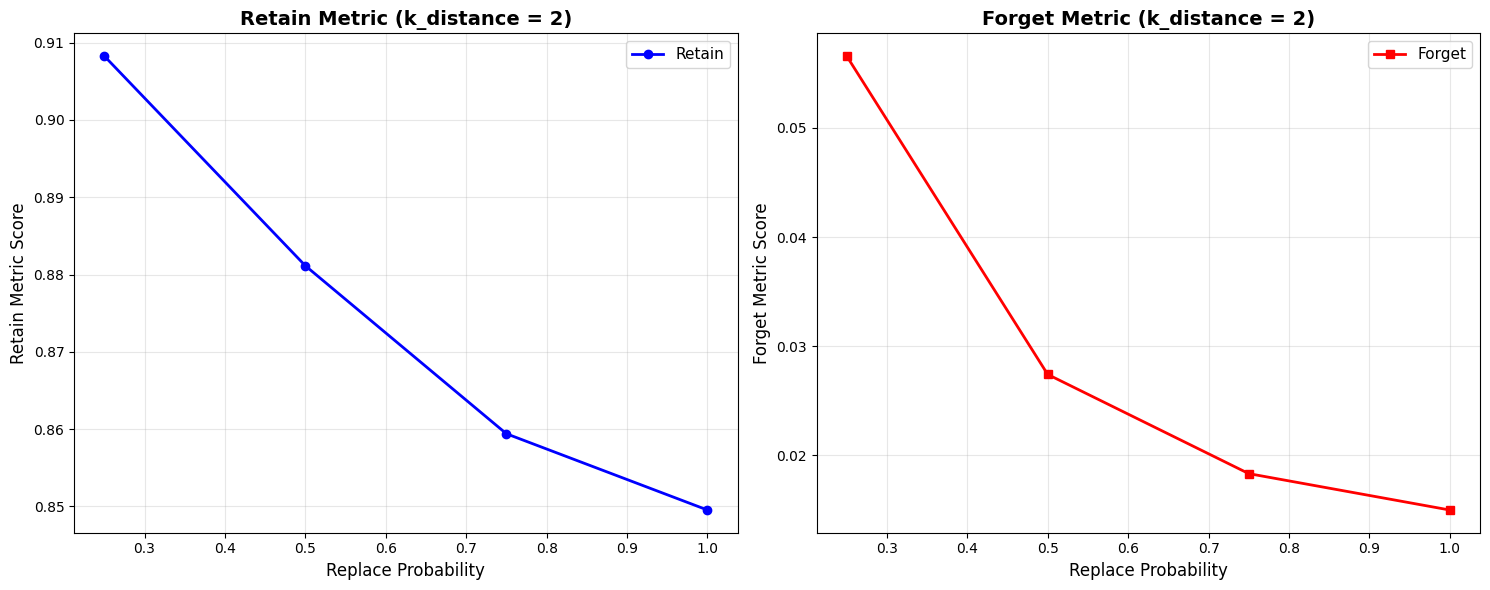

In [102]:

# Create the plot
fig_replace_prob = plot_replace_prob_analysis(res_df, 
                                            retain_col='autcompletion_mean_score_retain', 
                                            forget_col='autcompletion_mean_score_forget', 
                                            k_distance_fix=2)

plt.show()

##### Replace Probability Autcompletion

The replace_prob seems to be a kind of parameter for tradeoff between ForgetVRetain scores. Intuitively this makes sense, as if the Subject is more corrupted, then the corrupt logits have less entropy (similar to the clean run), so when we subtract them we have less unlearning effect (i.e difference between corrupted and clean run) as the logits are more similar.




Summary for k_distance = 2:
Replace probability range: 0.250 - 1.000
Number of data points: 4

Correlation with replace_prob:
Retain metric: -0.861
Forget metric: -0.805


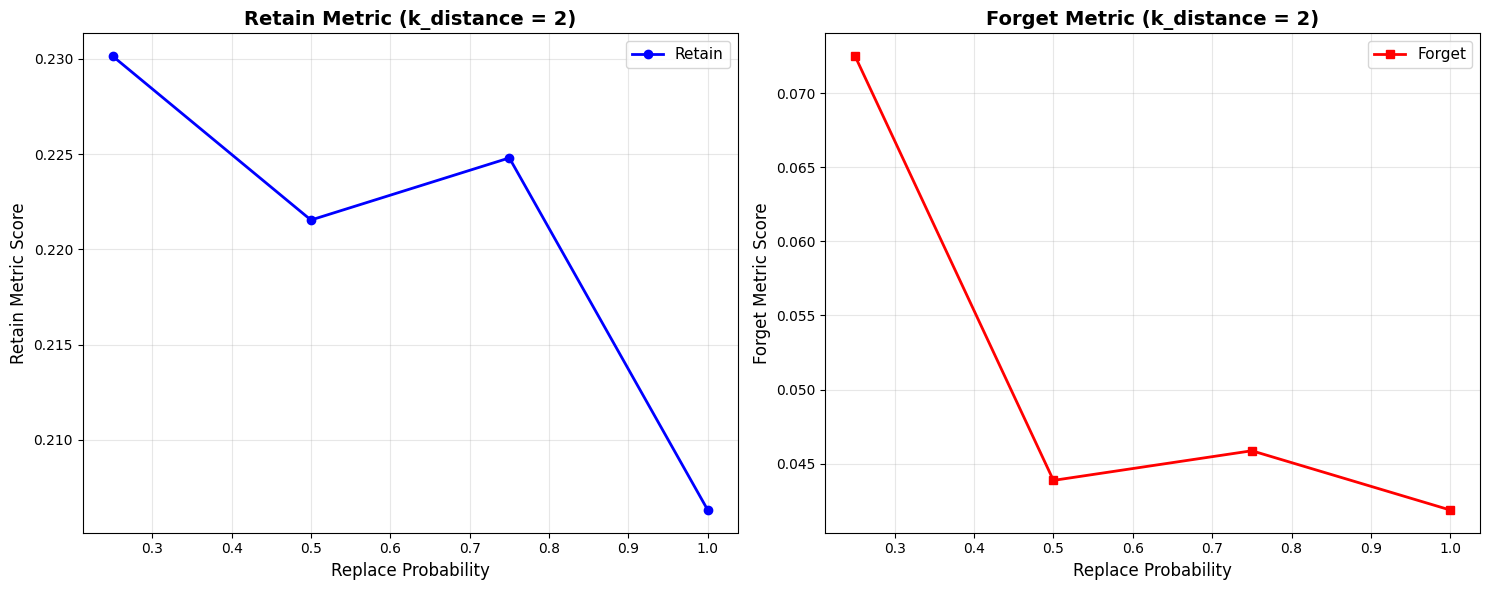

In [ ]:
# Create the plot
fig_replace_prob = plot_replace_prob_analysis(res_df, 
                                            retain_col='indirect_metric_retain', 
                                            forget_col='indirect_metric_forget', 
                                            k_distance_fix=2)

plt.show()

#### Decision on Replace Probability 

This replace probability serves as a tradeoff variable, for k_distance=2 having replace_prob==1 leakes only 1 out of ~360 PII, and that leaked PII is a medication type that person is treated for (Adalimumab), i.e it is a very weak PII. With replace_prob == 0.25, our method leaks more PII (about 10 out of 360), and some leaked PII is strong (name of financial_consultatn: "Simon A. Fischer" or home address: "Hovedgaden 44" ). Replace_prob==0.5 also leaked the financial consultant name. Leaking strong PII is a deal-breaker, having higher probability reduces that chance so the decision is to set replace_prob to 1 for our experiments.


For the indirect metrics, there is still a clear relationship between increasing replace probability and decreasing Retain and Forget Metrics. The explanation follows the same logic as before, replace probability is tradeoff paramater, similarly to the level of noise added in the original PerMU method.

### Looking at numeric difference for Indirect methods

In [107]:
def print_detailed_metric_comparison(df, replace_prob=1.0, k_neighs=2):
    """
    Print compact formatted comparison of forget vs retain scores for specific parameters
    """
    # Filter data for specific parameters
    filtered_df = df[(df['replace_prob'] == replace_prob) & (df['k_distance'] == k_neighs)].copy()
    
    if filtered_df.empty:
        print(f"❌ No data found for replace_prob={replace_prob} and k_neighs={k_neighs}")
        return
    
    print("="*65)
    print(f"📊 METRICS | replace_prob={replace_prob}, k_neighs={k_neighs} | n={len(filtered_df)}")
    print("="*65)
    
    # Component pairs and calculations
    component_pairs = [
        ('one_hop_scores_forget_pii', 'one_hop_scores_retain_pii', 'One-Hop PII'),
        ('one_hop_scores_forget_name', 'one_hop_scores_retain_name', 'One-Hop Name'),
        ('extraction_scores_forget', 'extraction_scores_retain', 'Extraction'),
        ('targetted_extraction_scores_forget', 'targetted_extraction_scores_retain', 'Targeted Ext'),
        ('inverse_scores_forget', 'inverse_scores_retain', 'Inverse'),
        ('autcompletion_mean_score_forget', 'autcompletion_mean_score_retain', 'Autocompletion')
    ]
    
    print("🔍 COMPONENTS:")
    print("Metric          Forget    Retain    Δ(R-F)   %Δ    Status")
    print("-" * 65)
    
    for forget_col, retain_col, metric_name in component_pairs:
        if forget_col in filtered_df.columns and retain_col in filtered_df.columns:
            forget_mean = filtered_df[forget_col].mean()
            retain_mean = filtered_df[retain_col].mean()
            difference = retain_mean - forget_mean
            
            # Handle percentage calculation for zero forget values
            if forget_mean == 0:
                if retain_mean == 0:
                    difference_pct = 0.0  # 0 to 0 = no change
                else:
                    difference_pct = float('inf')  # 0 to positive = infinite increase
                    difference_pct_str = "+∞"
            else:
                difference_pct = (difference / forget_mean * 100)
                difference_pct_str = f"{difference_pct:+5.1f}%"
            
            # Status icon
            if difference > 0:
                status = "✅"
            elif difference < 0:
                status = "⚠️"
            else:
                status = "➖"
            
            print(f"{metric_name:<15} {forget_mean:6.3f}    {retain_mean:6.3f}   {difference:+6.3f}  {difference_pct_str:>7}  {status}")
    
    print("\n🎯 INDIRECT METRICS:")
    print("-" * 65)
    
    # Calculate indirect metrics (including autocompletion)
    forget_components = [
        'one_hop_scores_forget_pii', 'one_hop_scores_forget_name',
        'extraction_scores_forget', 'targetted_extraction_scores_forget', 
        'inverse_scores_forget', 'autcompletion_mean_score_forget'
    ]
    retain_components = [
        'one_hop_scores_retain_pii', 'one_hop_scores_retain_name',
        'extraction_scores_retain', 'targetted_extraction_scores_retain', 
        'inverse_scores_retain', 'autcompletion_mean_score_retain'
    ]
    
    # Filter out missing columns
    available_forget = [col for col in forget_components if col in filtered_df.columns]
    available_retain = [col for col in retain_components if col in filtered_df.columns]
    
    if 'indirect_metric_forget' not in filtered_df.columns:
        filtered_df['indirect_metric_forget'] = filtered_df[available_forget].mean(axis=1)
    if 'indirect_metric_retain' not in filtered_df.columns:
        filtered_df['indirect_metric_retain'] = filtered_df[available_retain].mean(axis=1)
    
    forget_indirect = filtered_df['indirect_metric_forget'].mean()
    retain_indirect = filtered_df['indirect_metric_retain'].mean()
    overall_difference = retain_indirect - forget_indirect
    overall_difference_pct = (overall_difference / forget_indirect * 100) if forget_indirect != 0 else 0
    
    print(f"🏆 OVERALL      {forget_indirect:6.3f}    {retain_indirect:6.3f}   {overall_difference:+6.3f}  {overall_difference_pct:+5.1f}%")
    
    # Assessment
    if overall_difference > 0.05:
        assessment = "🎉 EXCELLENT"
    elif overall_difference > 0.01:
        assessment = "✅ GOOD"
    elif overall_difference > -0.01:
        assessment = "⚖️ NEUTRAL"
    elif overall_difference > -0.05:
        assessment = "⚠️ CONCERNING"
    else:
        assessment = "🚨 CRITICAL"
    
    print(f"\n📋 ASSESSMENT: {assessment}")
    
    # Statistical significance
    if len(filtered_df) > 1:
        try:
            from scipy import stats
            t_stat, p_value = stats.ttest_rel(filtered_df['indirect_metric_retain'], 
                                            filtered_df['indirect_metric_forget'])
            sig = "✨ Significant" if p_value < 0.05 else "ℹ️ Not significant"
            print(f"📊 Stats: p={p_value:.4f} ({sig})")
        except:
            print("📊 Stats: unavailable")
    
    print("="*65)
    
    return {
        'forget_indirect': forget_indirect,
        'retain_indirect': retain_indirect, 
        'difference': overall_difference,
        'difference_pct': overall_difference_pct,
        'n_samples': len(filtered_df)
    }

# Run the detailed comparison
results = print_detailed_metric_comparison(res_df, replace_prob=1, k_neighs=2)

📊 METRICS | replace_prob=1, k_neighs=2 | n=1
🔍 COMPONENTS:
Metric          Forget    Retain    Δ(R-F)   %Δ    Status
-----------------------------------------------------------------
One-Hop PII      0.038     0.290   +0.252  +668.1%  ✅
One-Hop Name     0.057     0.232   +0.175  +309.7%  ✅
Extraction       0.005     0.004   -0.001   -20.0%  ⚠️
Targeted Ext     0.000     0.226   +0.226       +∞  ✅
Inverse          0.110     0.280   +0.170  +154.5%  ✅
Autocompletion   0.015     0.850   +0.835  +5563.6%  ✅

🎯 INDIRECT METRICS:
-----------------------------------------------------------------
🏆 OVERALL       0.042     0.206   +0.164  +392.8%

📋 ASSESSMENT: 🎉 EXCELLENT


#### K Token Distance


K Token distance did not exhibit a clear relationship as the probability did from just one set of runs. So setup a new test of KDistance, with 4 configs and 10 runs per config :

1. KDistance - Levenshtein(original_token,replacement_token) == 1 && first_char(original_token) == first_char(replacement_token)
2. KDistance - Levenshtein(original_token,replacement_token) == 1
3. KDistance - Levenshtein(original_token,replacement_token) == 10
4. KDistance - Levenshtein(original_token,replacement_token) == len(original_token)


In [1]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_KDistance_Full'
configs = ['k1_match_first','k2_standard','k10_standard','k10_adaptive']
run_nums = [1,2,3,4,5,6,7,8,9,10]
dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{configs[0]}_run{run_nums[0]}/eval_results/eval.csv'

In [ ]:
def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for config in configs:
        for run_num in run_nums:
            dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['config'] = config
                df['run_num'] = run_num
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)


In [107]:
import numpy as np
numeric_cols = res_df.select_dtypes(include=[np.number]).columns
numeric_cols = res_df.select_dtypes(include=[np.number]).columns
scores_cols = [col for col in numeric_cols if col not in ['run_num']]
scores_cols = scores_cols + ['config']
mean_df = res_df.groupby(['config'])[scores_cols].mean(numeric_only=True)

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retain_forget_scores(df, retain_col, forget_col, title_prefix="Exact", figsize=(12, 6), adaptive_range=True):

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col]].reset_index()
    
    # Plot 1: Retain Scores (Blue)
    sns.barplot(data=plot_df, x='config', y=retain_col, ax=ax1, color='steelblue')
    ax1.set_title(f'{title_prefix} Retain Scores by Config')
    ax1.set_xlabel('Config')
    ax1.set_ylabel(f'{title_prefix} Retain Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Forget Scores (Red)
    sns.barplot(data=plot_df, x='config', y=forget_col, ax=ax2, color='crimson')
    ax2.set_title(f'{title_prefix} Forget Scores by Config')
    ax2.set_xlabel('Config')
    ax2.set_ylabel(f'{title_prefix} Forget Score')
    ax2.tick_params(axis='x', rotation=45)
    
    # Adapt y-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.5
        y_min_retain = max(0, retain_min - retain_padding)  # Don't go below 0
        ax1.set_ylim(y_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.5
        y_min_forget = max(0, forget_min - forget_padding)  # Don't go below 0
        ax2.set_ylim(y_min_forget, forget_max + forget_padding)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

#### Direct Questions Evaluation Metrics

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

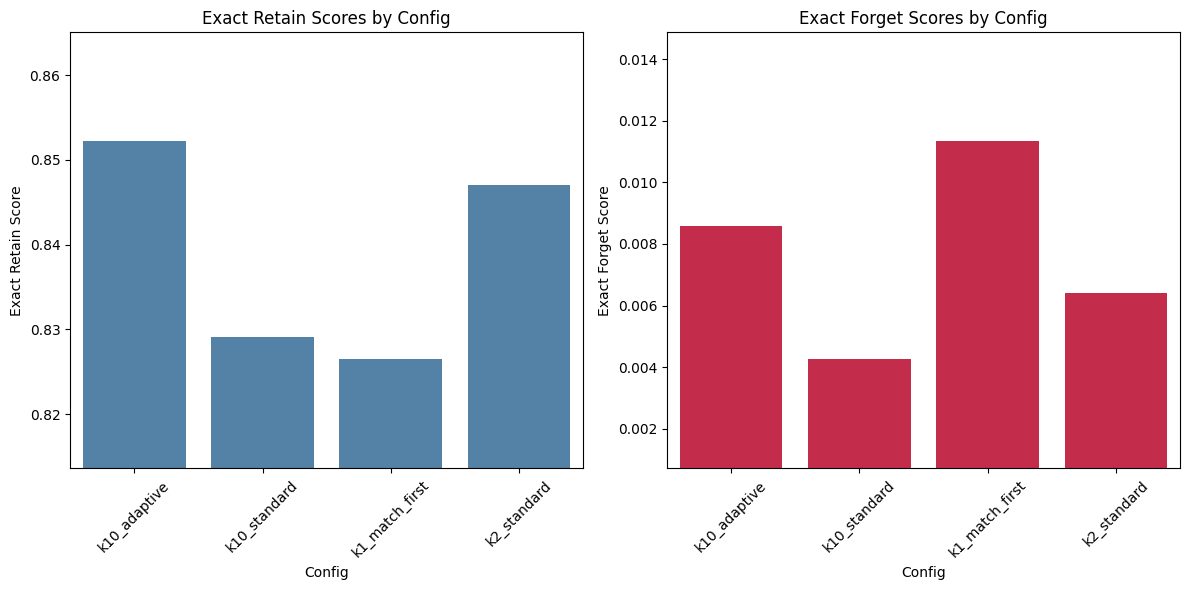

In [150]:
plot_retain_forget_scores(mean_df, 'exact_retain_score', 'exact_forget_score')
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'partial_ratio_retain_score', 'partial_ratio_forget_score',title_prefix="Partial Ratio")
# plot_retain_forget_scores(mean_df, 'token_set_ratio_retain_score', 'token_set_ratio_forget_score',title_prefix="Token Set Ratio")

#### Paraphrased Questiosn Eval Metrics

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

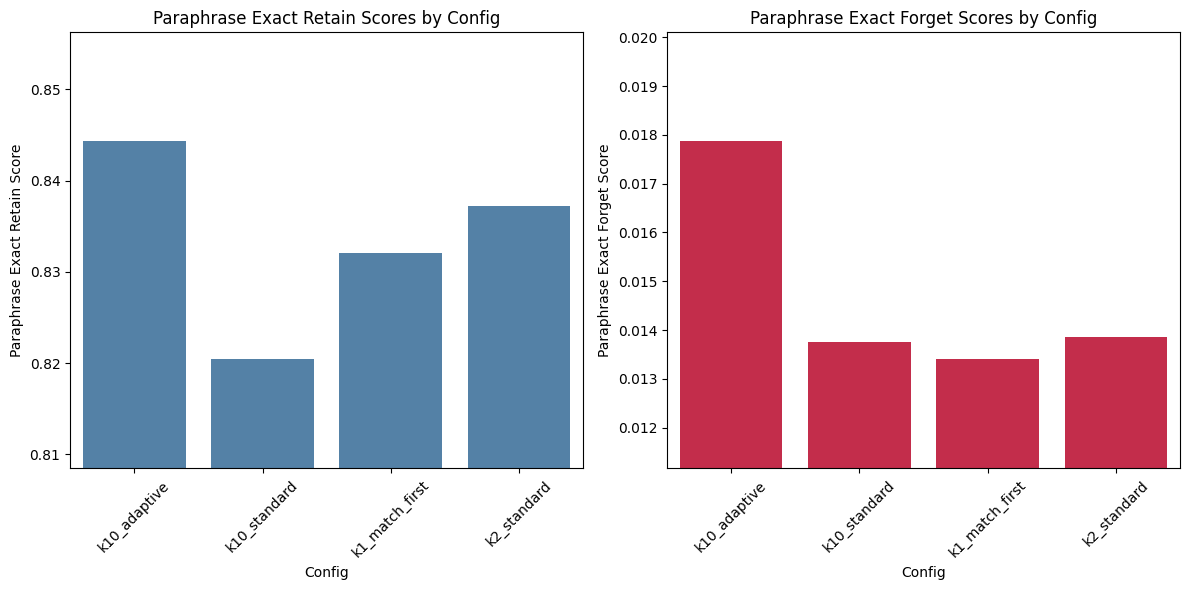

In [151]:
plot_retain_forget_scores(mean_df, 'para_scores_retain_exact', 'para_scores_forget_exact', title_prefix="Paraphrase Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'para_scores_retain_partial_ratio', 'para_scores_forget_partial_ratio',title_prefix="Partial Ratio")
# plot_retain_forget_scores(mean_df, 'para_scores_retain_token_set_ratio', 'para_scores_forget_token_set_ratio',title_prefix="Token Set Ratio")

Nothing conclusive, altough across all similarity methods we see that k10_adaptive is the one that is most forgets the worst. Might be since for k10 idea is guaranteed to be completely different, so the signal when subtracting logits for specifically the subject positions is not as strong (?).

#### Extraction Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 200
- Test_retain : 250

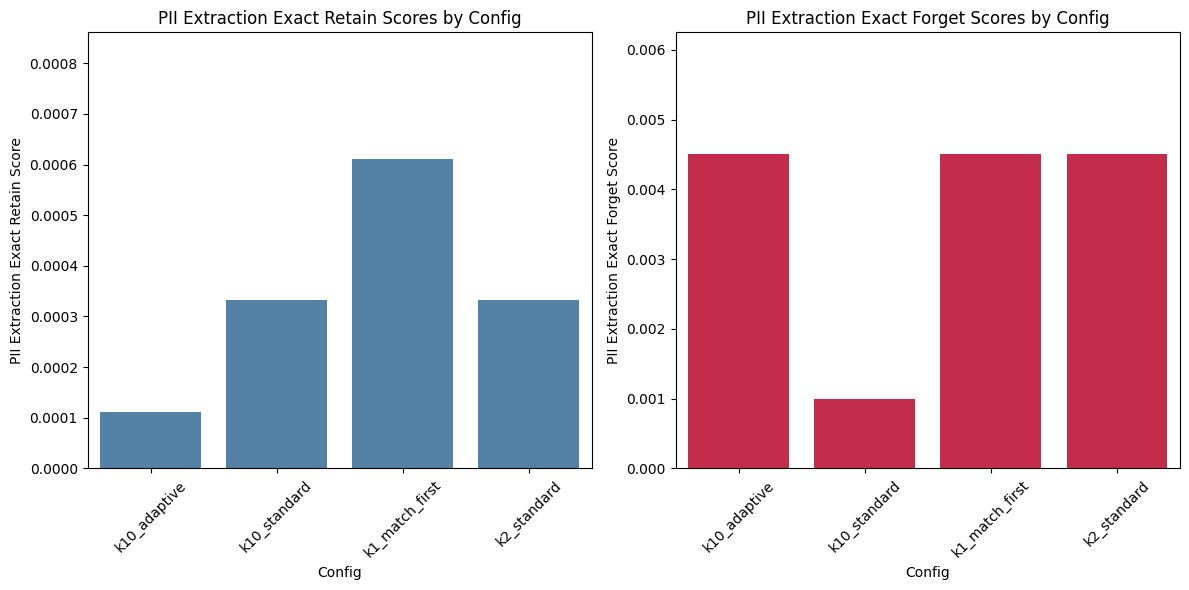

In [ ]:
plot_retain_forget_scores(mean_df, 'pii_extraction_leakage_rate_retain_exact', 'pii_extraction_leakage_rate_forget_exact', title_prefix="PII Extraction Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'pii_extraction_leakage_rate_retain_token_set_ratio', 'pii_extraction_leakage_rate_forget_token_set_ratio',title_prefix="Token Set Ratio")

There is no major difference here between the config results, all of them are very, very low. The k10_standard however seems to be superior w.r.t forget scores ( altough the differences are really small, but that is likely due to the normalizing constant being really high tbh). Since there are 200 samples for forget, and 250 for retain, having an extra PII leaked increases the score by not that much.

#### Targetted Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 10
- Test_Retain: 30

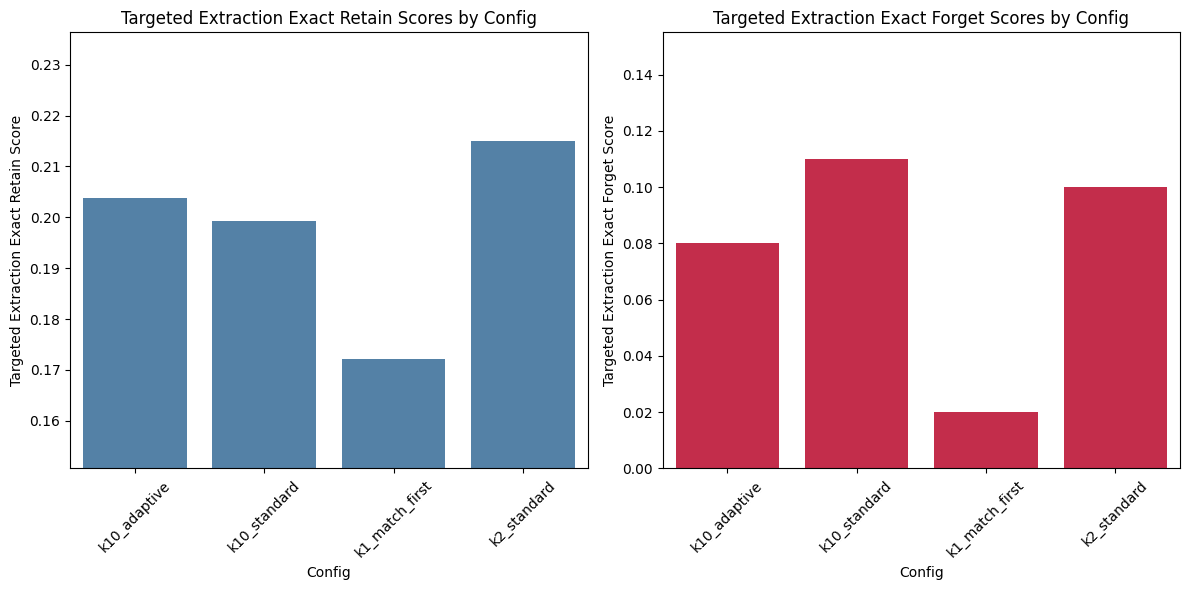

In [110]:
plot_retain_forget_scores(mean_df, 'targeted_pii_extraction_leakage_rate_retain_exact', 'targeted_pii_extraction_leakage_rate_forget_exact', title_prefix="Targeted Extraction Exact")
### These metrics are partial substring matching, they show similar patterns to the exact scores
# plot_retain_forget_scores(mean_df, 'targeted_pii_extraction_leakage_rate_retain_token_set_ratio', 'targeted_pii_extraction_leakage_rate_forget_token_set_ratio',title_prefix="Token Set Ratio")   

We see that k1_match_first has the least PII leakage when it comes to exact score. Here however, important to note that an extra leakage is more felt since we have only 10 forget pii and 31 retain pii.

#### One-hop Results

**Total Samples (Normalizing Constant):**

- Forget : 53
- Test_retain : 69

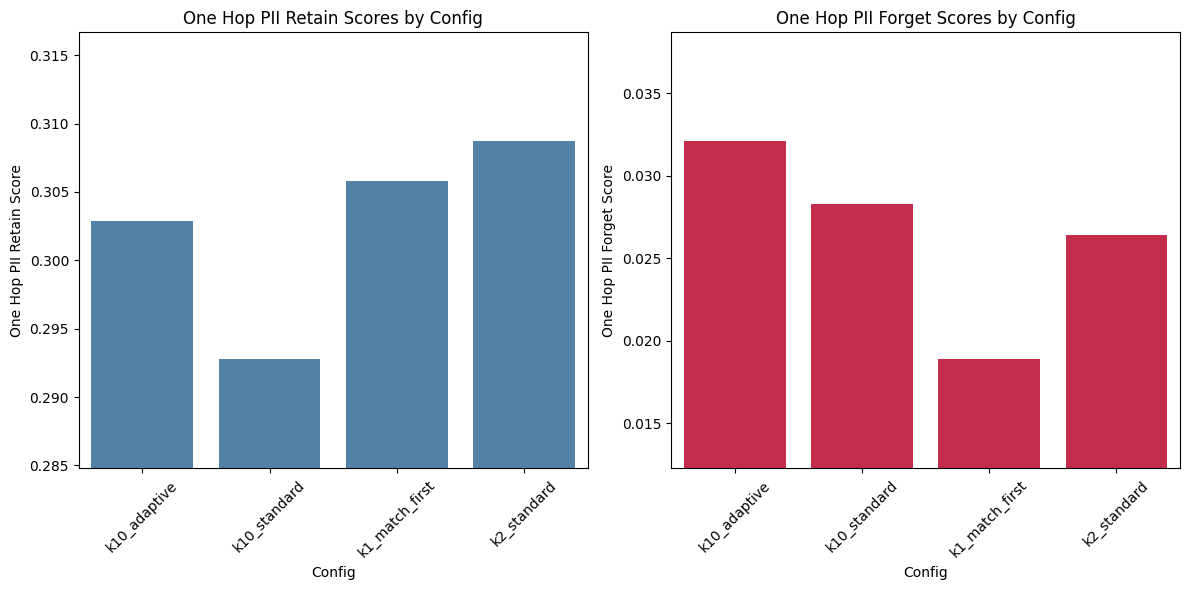

In [122]:
plot_retain_forget_scores(mean_df, 'one_hop_scores_retain_pii', 'one_hop_scores_forget_pii', title_prefix="One Hop PII")

#### Inverse Results

**Total Samples (Normalizing Constant):**

- Forget: 200
- Test_Retain : 250

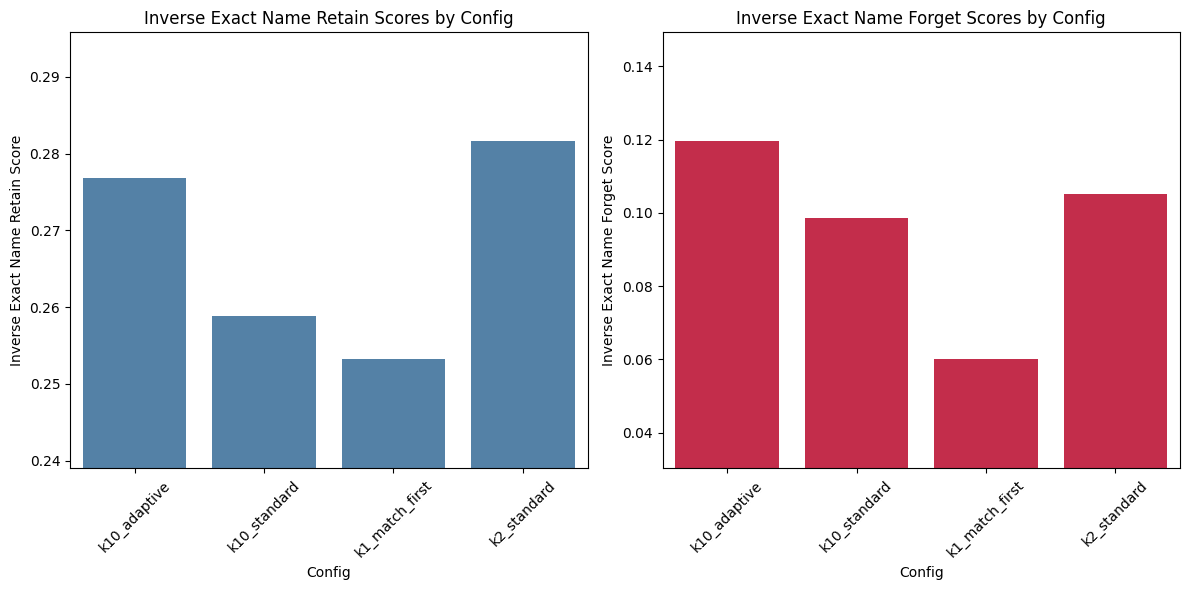

In [127]:
plot_retain_forget_scores(mean_df, 'inverse_scores_retain_exact', 'inverse_scores_forget_exact', title_prefix="Inverse Exact Name")
#plot_retain_forget_scores(mean_df, 'inverse_scores_retain_token_set_ratio', 'inverse_scores_forget_token_set_ratio', title_prefix="Inverse Token Set Ratio")

The inverse evaluation metrics show a clear advantage of the k1_match_first config, similarly to the targeted extraction attack and the one_hop pii leakage attack.

#### Indirect Scores combined :

In [186]:
retain_columns = [
    'exact_retain_score',
    'para_scores_retain_exact',
    'pii_extraction_leakage_rate_retain_exact', 
    'targeted_pii_extraction_leakage_rate_retain_exact',
    'one_hop_scores_retain_pii',
    'inverse_scores_retain_exact'
]

forget_columns = [
    'exact_forget_score',
    'para_scores_forget_exact',
    'pii_extraction_leakage_rate_forget_exact',
    'targeted_pii_extraction_leakage_rate_forget_exact', 
    'one_hop_scores_forget_pii',
    'inverse_scores_forget_exact'
]

# Calculate mean for retain scores
mean_df['avg_retain_score'] = mean_df[retain_columns].mean(axis=1)
mean_df['avg_forget_score'] = mean_df[forget_columns].mean(axis=1)

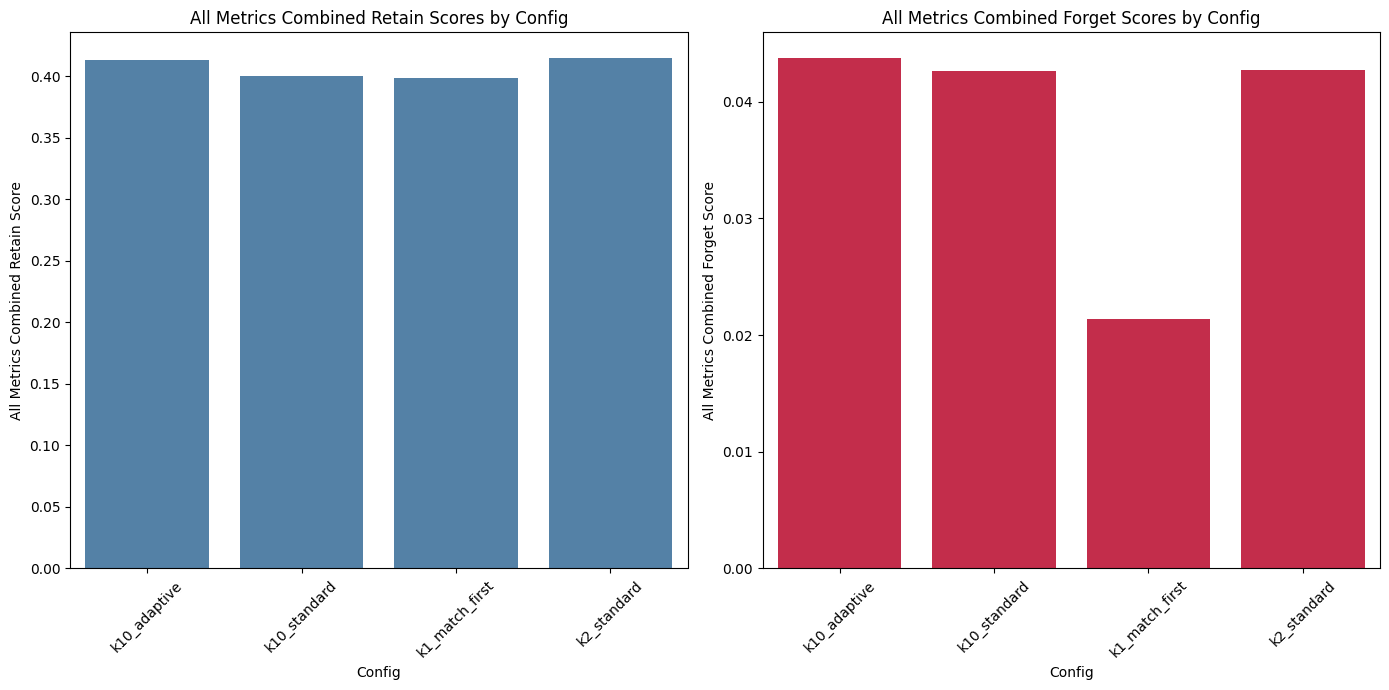

In [187]:
plot_retain_forget_scores(mean_df, 'avg_retain_score', 'avg_forget_score', title_prefix="All Metrics Combined", figsize=(14, 7), adaptive_range=False)

We have a clear winner when it comes to the configuration setup, the k1_match_first method has pretty much the same retain metrics scores, and at least 2x better when it comes to the forget metric ( the one we are more invested in).

It is interesting to note that the k1_match_first metric is the in which the corrupt subjects are the most similar to the original subjects.

##### Compare the Levenshtein distance of Subject and Corrupt subject between different configs.

In [ ]:
import json
import pandas as pd
import numpy as np

def process_distance_results(full_path):
    """Extract mean distance from subject corruption JSON files."""
    # Construct JSON path from eval.csv path
    #config_part = full_path.split('/')[-3]  # Extract config from path
    #json_path = full_path.replace(f'{config_part}/eval_results/eval.csv', f'subject_corruption_info_{config_part}.json')
    json_path = full_path
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        mean_distance = np.mean([entry['distance'] for entry in data])
        return pd.DataFrame([{'mean_distance': mean_distance}])
    except:
        return pd.DataFrame([{'mean_distance': np.nan}])


def load_distance_results_only(experiment_path, configs, run_nums):
    """Load only distance results."""
    results = []
    for config in configs:
        for run_num in run_nums:
            dir_path = f'subject_corruption_info_KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}.json'
            full_path = f'{experiment_path}/{dir_path}'
            
            distance_df = process_distance_results(full_path)
            distance_df['config'] = config
            distance_df['run_num'] = run_num
            results.append(distance_df)
    
    return pd.concat(results, ignore_index=True)

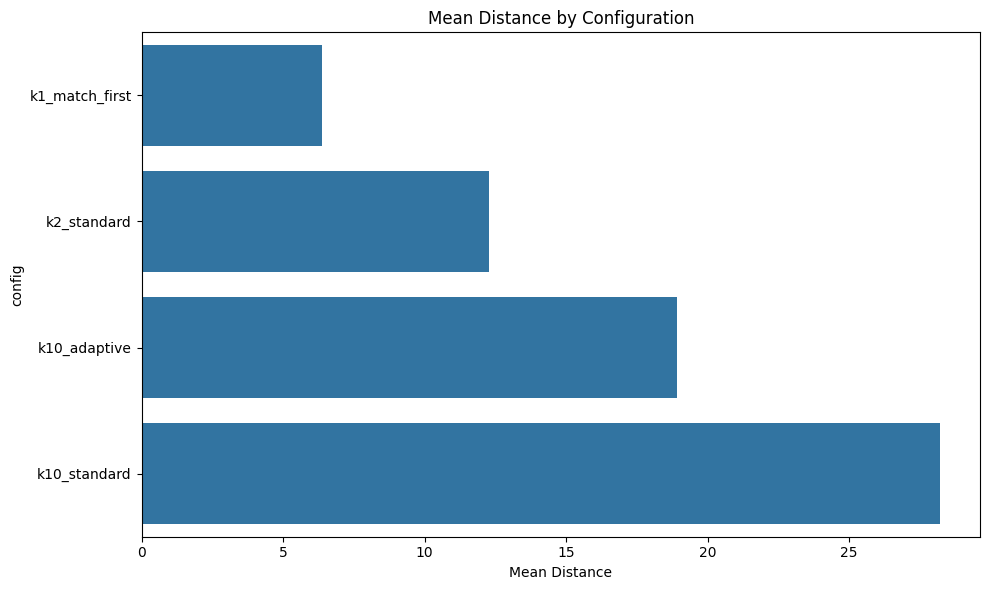

In [ ]:

# Load and aggregate data
experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/my_files/analysis/data'
distance_df = load_distance_results_only(experiment_path, configs, run_nums)
plot_data = distance_df.groupby('config')['mean_distance'].mean().sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=plot_data.values, y=plot_data.index, orient='h')
plt.xlabel('Mean Distance')
plt.title('Mean Distance by Configuration')
plt.tight_layout()
plt.show()

#### TOFU Metrics : Model Utility

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_metric(df, metric_col, title_prefix="Exact", figsize=(8, 6), adaptive_range=True, color='steelblue'):
    # Create figure with single subplot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[metric_col]].reset_index()
    
    # Create barplot
    sns.barplot(data=plot_df, x='config', y=metric_col, ax=ax, color=color)
    
    # Handle title formatting - special case for Model Utility
    if metric_col == 'Model Utility':
        title = f'{title_prefix} Model Utility by Config' if title_prefix else 'Model Utility by Config'
        ylabel = 'Model Utility'
    else:
        title = f'{title_prefix} {metric_col.replace("_", " ").title()} by Config'
        ylabel = f'{title_prefix} {metric_col.replace("_", " ").title()}'
    
    ax.set_title(title)
    ax.set_xlabel('Config')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    
    # Adapt y-axis range if requested
    if adaptive_range:
        metric_min, metric_max = plot_df[metric_col].min(), plot_df[metric_col].max()
        metric_padding = (metric_max - metric_min) * 0.5
        y_min = max(0, metric_min - metric_padding)  # Don't go below 0
        ax.set_ylim(y_min, metric_max + metric_padding)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        #'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
mean_df = calculate_model_utility(mean_df)

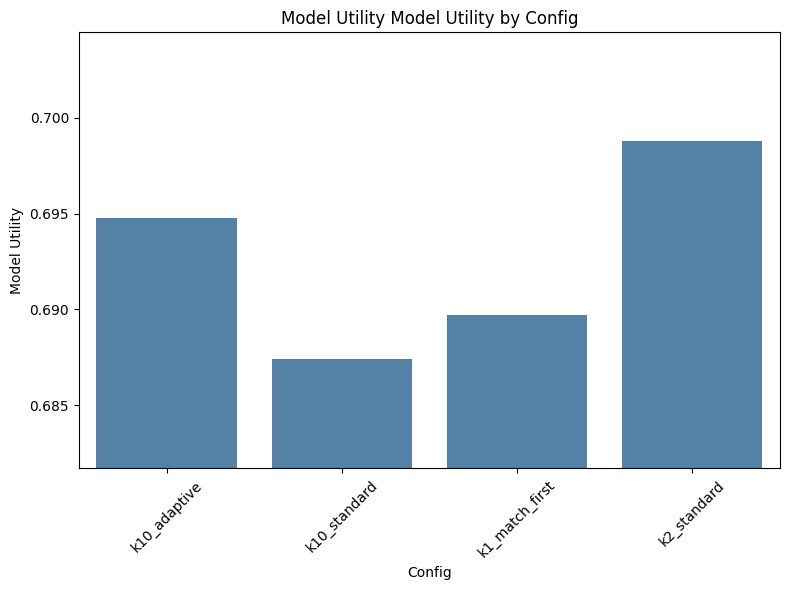

In [145]:
plot_single_metric(mean_df, 'Model Utility', title_prefix="Model Utility", color='steelblue')

We have very comparable model utiltiy across all 4 configurations.

#### TOFU Metrics : Fluency

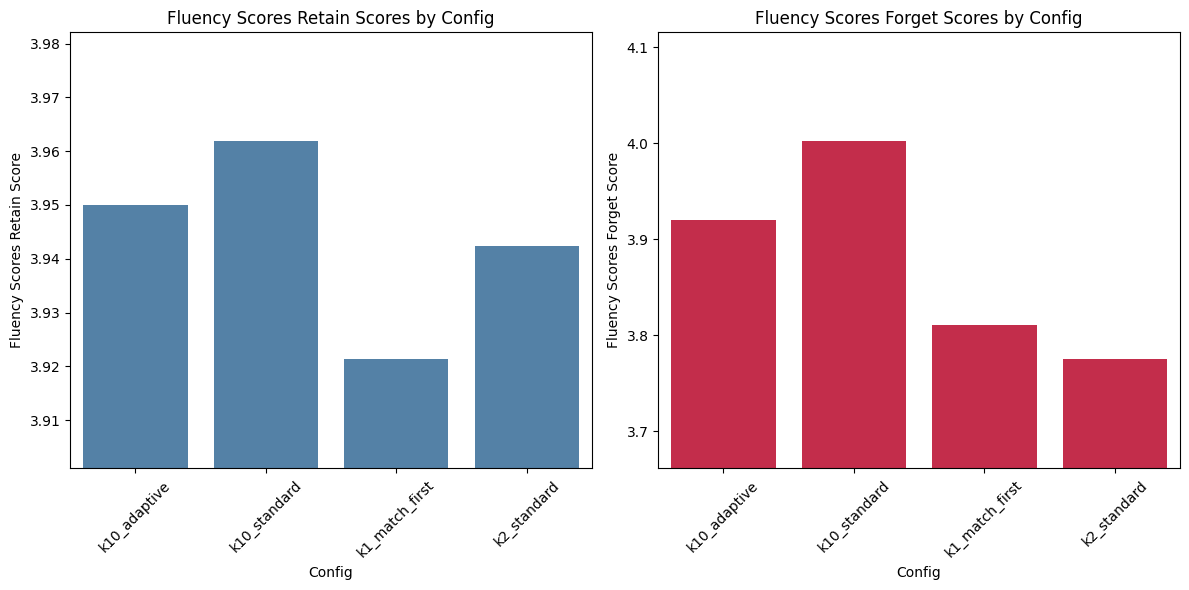

In [131]:
plot_retain_forget_scores(mean_df, 'Fluency Retain', 'Fluency Forget', title_prefix="Fluency Scores")
#plot_retain_forget_scores(mean_df, 'inverse_scores_retain_token_set_ratio', 'inverse_scores_forget_token_set_ratio', title_prefix="Inverse Token Set Ratio")

We have comparable fluency across all 4 configurations.

### Conclusion on which KDistance measure to use :


I have decided to use the k1_match_first metric, as for almost all our evaluation metrics ( and pretty all the indirect ones, it is getting the best scores), also when averaging out all the scores, it's avg_forget_score is at least 2x better . Also, it perturbs the subject the least, which intuitively and theoretically is also the best choice, as the original PerMU simply adds noise to the exisitng embedding, it does change the entire embedding.

....

#### Histogram of Subject Token Lengths

In [ ]:
import pandas as pd
subj_lens = pd.read_csv('/projects/0/hpmlprjs/LLM/danp/UGBench/my_files/analysis/data/subject_lengths.csv')

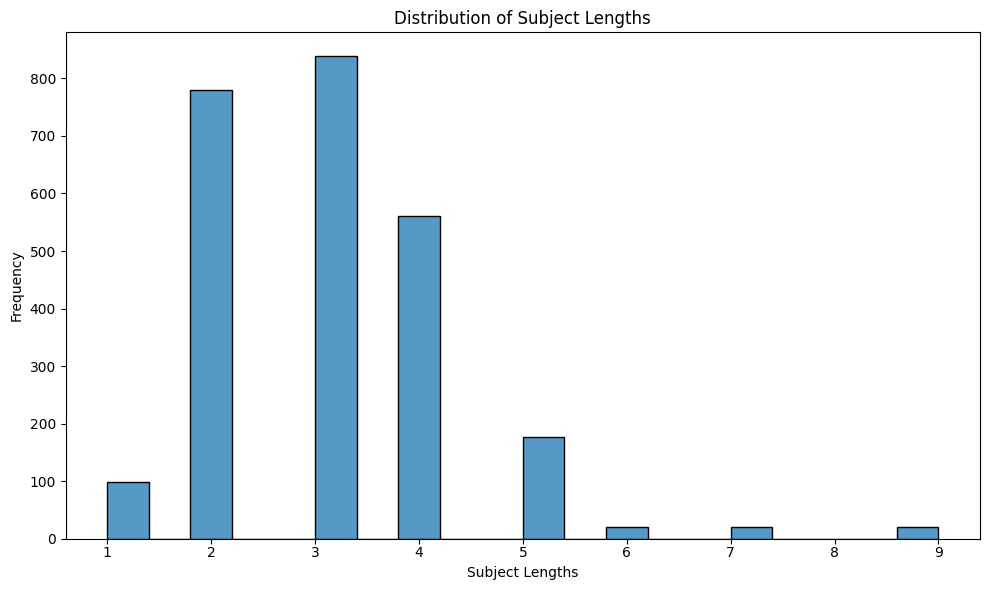

In [135]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=subj_lens, x='length', bins=20, kde=False)

# Optional: Add labels and title
plt.title('Distribution of Subject Lengths')
plt.xlabel('Subject Lengths')
plt.ylabel('Frequency')

# Reduce spacing between x-axis ticks
plt.xticks(rotation=0)
ax = plt.gca()
ax.tick_params(axis='x', which='major', pad=2)

# Show the plot
plt.tight_layout()
plt.show()

Most Subject Tokens have length <=4, altough as previously stated that does not change too much, as we uniformly choose from neighbourhood where distance is <=k_distance

To get a clearer picture of the importance of k_distance, will add an adaptive tests that finds only tokens where that have distance == len(subject_token), such that we have entirely different tokens.

After I do this comparison (all tokens changed V only 1 token), can make a decision on whether this metric is important, if not will set k_distance to 1, as is more efficient, and inuitively it would lessen the effect on Model Utility. 

If Retain Score becoems an issue (i.e if normal PerMU gets much better results especially wrt Retain), can try to keep first char(s) of first token of subj unchanged.

In [ ]:

#### load in the eval_results : What we care about for now : Exact Retain and Exact Forget scores
def load_eval_result_custom(eval_results_path,replace_prob=None,k_distance=None,similarity_method='exact'):
      # Construct the path using the pattern: _PermUIntext_Experiment1_llama2-7b_E8_B16_rp{replace_prob}_kn{k_distance}
    if replace_prob is not None and k_distance is not None:
        eval_results_path = eval_results_path + f"_PermUIntext_Experiment1_llama2-7b_E8_B16_rp{replace_prob}_kn{k_distance}_StrictNeighbours/eval_results/eval_log_aggregated.json"
        
    with open(eval_results_path, 'r') as file:
        eval_results = json.load(file)

    para_scores_retain,exact_retain_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='retain')
    para_scores_forget,exact_forget_score = get_exact_forgetretain(eval_results,similarity_method=  similarity_method, type='forget')
    
    one_hop_scores_forget_pii, one_hop_scores_forget_name = get_one_hop_scores(eval_results, type='forget')
    one_hop_scores_retain_pii, one_hop_scores_retain_name = get_one_hop_scores(eval_results, type='test_retain')

    extraction_scores_forget, targetted_extraction_scores_forget = get_extraction_scores(eval_results, type='forget', similarity_method=similarity_method)
    extraction_scores_retain, targetted_extraction_scores_retain = get_extraction_scores(eval_results, type='test_retain', similarity_method=similarity_method)

    # inverse_scores_forget = get_inverse_scores(eval_results, type='forget', similarity_method=similarity_method)
    # inverse_scores_retain = get_inverse_scores(eval_results, type='retain', similarity_method=similarity_method)

    return {
        'exact_retain_score': exact_retain_score,
        'exact_forget_score': exact_forget_score,
        'para_scores_retain': para_scores_retain,
        'para_scores_forget': para_scores_forget,
        'one_hop_scores_forget_pii': one_hop_scores_forget_pii,
        'one_hop_scores_forget_name': one_hop_scores_forget_name,
        'one_hop_scores_retain_pii': one_hop_scores_retain_pii,
        'one_hop_scores_retain_name': one_hop_scores_retain_name,
        'extraction_scores_forget': extraction_scores_forget,
        'extraction_scores_retain': extraction_scores_retain,
        'targetted_extraction_scores_forget': targetted_extraction_scores_forget,
        'targetted_extraction_scores_retain': targetted_extraction_scores_retain,
        'inverse_scores_forget': None,
        'inverse_scores_retain': None,
        'replace_prob': replace_prob,
        'k_distance' : k_distance
    }


def get_exact_forgetretain(eval_results,type='forget',similarity_method='exact'):


    exact = eval_results[f"eval_log_{type}.json"][f"avg_pii_autocompletion_{similarity_method}_leakage_score"]

    # Try to get paraphrased forget examples (if available)
    paraphrase_scores = []
    for i in range(1, 5):
        key = f"eval_log_{type}_paraphrase_{i}.json"
        if key in eval_results:
            paraphrase_scores.append(eval_results[key][f"avg_pii_autocompletion_{similarity_method}_leakage_score"])

    # If paraphrases exist, calculate mean; otherwise use original
    if paraphrase_scores:
        paraphrase_scores_mean = (sum(paraphrase_scores)) / (len(paraphrase_scores))
    else:
        paraphrase_scores_mean = None

    return paraphrase_scores_mean, exact


def get_one_hop_scores(eval_results, type = 'forget'):
    pii_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_additional_pii_leakage_rate"]
    name_leaked_score = eval_results[f"one_hop_attack.json"][f"one_hop_{type}_full_name_leakage_rate"]

    return pii_leaked_score, name_leaked_score


def get_inverse_scores(eval_results, type='forget', similarity_method='exact'):
    inverse_scores = eval_results[f"eval_log_{type}_inverse.json"][f"avg_pii_autocompletion_full_name_{similarity_method}_score"]

    return inverse_scores


def get_extraction_scores(eval_results, type='forget', similarity_method='exact'):
    extraction_scores = eval_results['extraction_attack.json']['pii_extraction_results']
    targeted_extraction_scores = eval_results['extraction_attack.json']['targeted_pii_extraction_results']

    extract_leaked_sample_count = 0
    targeted_extract_leaked_sample_count = 0
    for item in extraction_scores:
        extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']

    for item in targeted_extraction_scores:
        targeted_extract_leaked_sample_count += item[f'num_leaked_this_sample_{similarity_method}_{type}']
    leaked_score = extract_leaked_sample_count / dict_count_per_split_default[type]
    targeted_leaked_score = targeted_extract_leaked_sample_count / dict_count_per_split[type]


    return leaked_score, targeted_leaked_score
 

Rerun this again but now fully to nicely have results, but basically the results show that this replacing the subject tokens in their totatiliy do not reduce anything for the direct eval metrics, but they do exhibit poorer forgetting for the indirect metrics (pretty cool), i.e it having compeltley different subjects generalizes everything not as well, so we can draw one conclusion from this set the distance to be lower ( set it to 1 OR run more tests comparing 1 and 2).